# Emojify!

Use word vector representations to build an Emojifier. 

In [1]:
# packages
import numpy as np
from emo_utils import *
import emoji
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Emojifier-V1

### Dataset EMOJISET

- X contains 127 sentences (strings).
- Y contains an integer label between 0 and 4 corresponding to an emoji for each sentence.

Split the dataset between training (127 examples) and testing (56 examples).

In [5]:
X_train, Y_train = read_csv('data/train_emoji.csv')
X_test, Y_test = read_csv('data/tesss.csv')
maxLen = len(max(X_train, key=len).split())

for idx in range(10):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit 😞
congratulations on your acceptance 😄
The assignment is too long  😞
I want to go play ⚾


### Overview of the Emojifier-V1

#### Inputs and Outputs
* **Input**: a sentence (e.g. "I love you). 
* **Output**: a probability vector (1,5) (5 choices of emojis)

Convert $Y$ from $(m, 1)$ into a "one-hot representation" $(m, 5)$, 

In [6]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

idx = 50
print(f"Sentence '{X_train[50]}' has label index {Y_train[idx]}, which is emoji {label_to_emoji(Y_train[idx])}", )
print(f"Label index {Y_train[idx]} in one-hot encoding format is {Y_oh_train[idx]}")

Sentence 'I missed you' has label index 0, which is emoji ❤️
Label index 0 in one-hot encoding format is [ 1.  0.  0.  0.  0.]


### Implementing Emojifier-V1

* Convert each word in the input sentence into their 50-dim GloVe word vector representations.
* Take an average of the word vectors. 

In [7]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('../../readonly/glove.6B.50d.txt')

word = "cucumber"
idx = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


**`sentence_to_avg() Overview`**

`Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
and averages its value into a single vector encoding the meaning of the sentence.`

**`Arguments`**
```
sentence -- string, one training example from X
word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
```
**`Returns`**
```
avg -- average vector encoding information about the sentence, numpy-array of shape (50,)
```

In [8]:
def sentence_to_avg(sentence, word_to_vec_map):
    
    words = sentence.lower().split()        # split sentence into list of lower case words
    avg = np.zeros((50, 1))                 # initialize average word vector
    
    total = 0                               # average the vectors
    for w in words:
        total += word_to_vec_map[w]
    avg = total / len(words)
    
    return avg

#### Model

$$ z^{(i)} = W . avg^{(i)} + b$$

$$ a^{(i)} = softmax(z^{(i)})$$

$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Y_{oh,k}^{(i)} * log(a^{(i)}_k)$$

**`model() Overview`**

`Model to train word vector representations in numpy.`

**`Arguments`**
```
X -- input data, numpy array of sentences as strings, of shape (m, 1)
Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
learning_rate -- learning_rate for the stochastic gradient descent algorithm
num_iterations -- number of iterations
```
**`Returns`**
```
pred -- vector of predictions, numpy-array of shape (m, 1)
W -- weight matrix of the softmax layer, of shape (n_y, n_h)
b -- bias of the softmax layer, of shape (n_y,)
```

In [10]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    
    np.random.seed(1)
    m = Y.shape[0]                          # number of training examples
    n_y = 5                                 # number of classes  
    n_h = 50                                # dimensions of the GloVe vectors 
    
    
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)   # xavier initialization of parameters
    b = np.zeros((n_y,))
    
    Y_oh = convert_to_one_hot(Y, C = n_y)          # convert Y to Y_onehot with n_y classes
    
    for t in range(num_iterations):
        for i in range(m):
            
            avg = sentence_to_avg(X[i], word_to_vec_map)  # average word vectors of the ith example
            z = np.dot(W, avg) + b                        # forward propagate the avg through softmax
            a = softmax(z)
            cost = - np.sum(Y_oh[i] * np.log(a))          # compute cost
            
            # compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # update parameters
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b

In [12]:
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = 1.95204988128
Accuracy: 0.348484848485
Epoch: 100 --- cost = 0.0797181872601
Accuracy: 0.931818181818
Epoch: 200 --- cost = 0.0445636924368
Accuracy: 0.954545454545
Epoch: 300 --- cost = 0.0343226737879
Accuracy: 0.969696969697
[[ 3.]
 [ 2.]
 [ 3.]
 [ 0.]
 [ 4.]
 [ 0.]
 [ 3.]
 [ 2.]
 [ 3.]
 [ 1.]
 [ 3.]
 [ 3.]
 [ 1.]
 [ 3.]
 [ 2.]
 [ 3.]
 [ 2.]
 [ 3.]
 [ 1.]
 [ 2.]
 [ 3.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 1.]
 [ 4.]
 [ 3.]
 [ 3.]
 [ 4.]
 [ 0.]
 [ 3.]
 [ 4.]
 [ 2.]
 [ 0.]
 [ 3.]
 [ 2.]
 [ 2.]
 [ 3.]
 [ 4.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 2.]
 [ 3.]
 [ 0.]
 [ 3.]
 [ 2.]
 [ 4.]
 [ 3.]
 [ 0.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 4.]
 [ 2.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 2.]
 [ 3.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 3.]
 [ 4.]
 [ 4.]
 [ 2.]
 [ 2.]
 [ 1.]
 [ 2.]
 [ 0.]
 [ 3.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 3.]
 [ 3.]
 [ 1.]
 [ 2.]
 [ 1.]
 [ 2.]
 [ 2.]
 [ 4.]
 [ 3.]
 [ 3.]
 [ 2.]
 [ 4.]
 [ 0.]
 [ 0.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 2.]
 [ 0.]
 [ 1.]
 [ 2.]
 [ 3.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 3.]
 [ 2.]
 [ 2.]
 [ 

### Test Set Performance 

In [13]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.977272727273
Test set:
Accuracy: 0.857142857143


In [14]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.833333333333

i adore you ❤️
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😄


(56,)
           ❤️    ⚾    😄    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    6    7
All          9    9   19   13    6   56


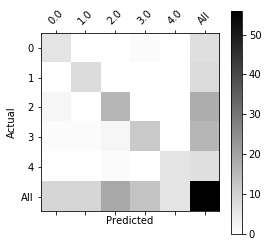

In [15]:
# confusion matrix - shows how often an example is mislabeled

print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

## 2. Emojifier-V2: Using LSTMs in Keras

This time, we will build an LSTM model that takes word **sequences** as input, and will be able to account for the word ordering. 

In [16]:
# packages
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)

Using TensorFlow backend.


### Model Overview

### Keras and Mini-batching 

We want to train Keras using mini-batches. However, most deep learning frameworks require that all sequences in the same mini-batch have the **same length** due to vectorization. The common solution is to use padding. We can set a maximum sequence length, and pad all sequences to have the same length. 

### The Embedding Layer

The **embedding matrix** maps word indices to embedding vectors. In Keras, the embedding matrix is represented as a "layer", and can be derived by either training a model to derive the embeddings from scratch, or using a pretrained embedding.

**Input**: an integer matrix (batch size, max input length) corresponding to sentences converted into lists of indices.

**Output**: an array (batch size, max input length, dimension of word vectors)

<img src="images/embedding1.png" style="width:700px;height:250px;">
<caption><center> Embedding layer</center></caption>

**`sentences_to_indices() Overview`**

`Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences. The output shape should be such that it can be given to Embedding().`

**`Arguments`**
```
X -- array of sentences (strings), of shape (m, 1)
word_to_index -- a dictionary containing the each word mapped to its index
max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
```
**`Returns`**
```
X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
```


In [18]:
def sentences_to_indices(X, word_to_index, max_len):

    m = X.shape[0]                                   # number of training examples
    X_indices = np.zeros((m, max_len))               # initialize X_indices    
    
    for i in range(m):                               # loop over training examples
        
        sentence_words = X[i].lower().split()

        j = 0

        for w in sentence_words:
            X_indices[i, j] = word_to_index[w]
            j = j + 1
            
    return X_indices

#### Build embedding layer

* Use pre-trained word vectors to build the `Embedding()` layer in Keras  
* The embedding layer takes as input a list of word indices and returns the word embeddings for a sentence 

**`pretrained_embedding_layer() Overview`**

`Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.`

**`Arguments`**
```
word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)
```
**`Returns`**
```
embedding_layer -- pretrained layer Keras instance
```

In [20]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    
    vocab_len = len(word_to_index) + 1               # add 1 for unknown words
    emb_dim = word_to_vec_map["cucumber"].shape[0]   # define dimensionality of GloVe word vectors (50)
    emb_matrix = np.zeros((vocab_len, emb_dim))      # initialize embedding matrix
    
    for word, idx in word_to_index.items():          # fill in each row with word vector representation
        emb_matrix[idx, :] = word_to_vec_map[word]

    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)  # define Keras embedding layer
    embedding_layer.build((None,))                                    # build embedding layer  
    embedding_layer.set_weights([emb_matrix])   # set weights of embedding layer to embedding matrix
    
    return embedding_layer

## 2.3 Building the Emojifier-V2

<img src="images/emojifier-v2.png" style="width:700px;height:400px;"> <br>
<caption><center> **Figure 3**: Emojifier-v2. A 2-layer LSTM sequence classifier. </center></caption>

**Input**: an array of sentences of shape (`m`, `max_len`, ) defined by `input_shape`.

**Output**: a softmax probability vector of shape (`m`, `C = 5`). 

**`Emojify_V2() Overview`**

`Function creating the Emojify-v2 model's graph.`

**`Arguments`**
```
input_shape -- shape of the input, usually (max_len,)
word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)
```
**`Returns`**
```
model -- a model instance in Keras
```

In [22]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    
    sentence_indices = Input(input_shape, dtype='int32') # define input
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)  # create pretrained embedding layer
    embeddings = embedding_layer(sentence_indices)     # propagate sentence_indices through embedding layer
    
    X = LSTM(units=128, return_sequences=True)(embeddings)  # LSTM layer with 128-dimensional hidden state
    X = Dropout(0.5)(X)                                     # dropout (0.5)
    X = LSTM(128, return_sequences=False)(X)                # LSTM layer with 128-dimensional hidden state
    X = Dropout(0.5)(X)                                     # dropout (0.5)      
    X = Dense(5)(X)                                         # 5 unit Dense layer
    X = Activation('softmax')(X)                            # softmax
    
    model = Model(inputs=sentence_indices, outputs=X)       # convert sentence_indices into X
    
    return model

In [23]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
__________

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # compile model

X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)  # convert to indices
Y_train_oh = convert_to_one_hot(Y_train, C = 5)                         # convert to one-hot

model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)  # fit

Epoch 1/50
132/132 [==============================] - 0s - loss: 1.6083 - acc: 0.1970     
Epoch 2/50
132/132 [==============================] - 0s - loss: 1.5322 - acc: 0.2955     
Epoch 3/50
132/132 [==============================] - 0s - loss: 1.5008 - acc: 0.3258     
Epoch 4/50
132/132 [==============================] - 0s - loss: 1.4385 - acc: 0.3561     
Epoch 5/50
132/132 [==============================] - 0s - loss: 1.3470 - acc: 0.4545     
Epoch 6/50
132/132 [==============================] - 0s - loss: 1.2333 - acc: 0.5076     
Epoch 7/50
132/132 [==============================] - 0s - loss: 1.1759 - acc: 0.4470     
Epoch 8/50
132/132 [==============================] - 0s - loss: 1.0540 - acc: 0.5758     
Epoch 9/50
132/132 [==============================] - 0s - loss: 0.8766 - acc: 0.7121     
Epoch 10/50
132/132 [==============================] - 0s - loss: 0.8229 - acc: 0.6970     
Epoch 11/50
132/132 [==============================] - 0s - loss: 0.7027 - acc: 0.7500   

In [25]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

32/56 [================>.............] - ETA: 0s
Test accuracy =  0.821428562914


In [26]:
# mislabelled examples
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

Expected emoji:😄 prediction: she got me a nice present	❤️
Expected emoji:😞 prediction: work is hard	😄
Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:🍴 prediction: any suggestions for dinner	😄
Expected emoji:❤️ prediction: I love taking breaks	😞
Expected emoji:😄 prediction: you brighten my day	❤️
Expected emoji:😄 prediction: will you be my valentine	❤️
Expected emoji:🍴 prediction: See you at the restaurant	😄
Expected emoji:😞 prediction: go away	⚾
Expected emoji:🍴 prediction: I did not have breakfast ❤️


In [30]:
x_test = np.array(['I do not like going outside'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

I do not like going outside 😞
